# ch05.14. 실전 머신러닝 - 자전거 수요 예측

---
* 날짜: 2022-06-02
* 이름: 고민수

## 학습내용
    - 실제 대회의 데이터셋을 이용해 모델링한다.
    - 성능향상을 위한 작업을 진행한다

## 학습자료

* https://github.com/BaekKyunShin/musthave_mldl_problem_solving_strategy
* https://www.kaggle.com/c/bike-sharing-demand
* https://www.kaggle.com/competitions/bike-sharing-demand/code?competitionId=3948&sortBy=scoreAscending 

## 데이터 불러오기 및 기본 탐색
---

* output 
  * train, test, submission (csv file)
  * noms, cont (리스트)

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### | 데이터 확보

* 경로 설정

In [2]:
ds_path =  '/content/drive/MyDrive/dataset/bike-sharing-demand'

* 데이터셋 읽기

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv(f'data/test.csv')
submission = pd.read_csv(f'data/sampleSubmission.csv')
print(train.shape, test.shape, submission.shape)

(10886, 12) (6493, 9) (6493, 2)


* train  파일 확인

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


* test 파일 확인

In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


* train 요약

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


* test 요약

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### | 피쳐 분포 시각화

* 타겟 (count) 분포 확인

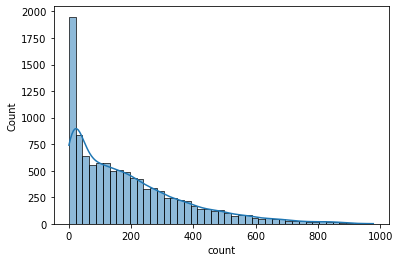

In [8]:
# 타겟 ; 연속, 회귀문제
sns.histplot(train['count'], kde=True)
plt.show()
# 로그 스케일로 변환 필요

* train 피쳐 분포 확인

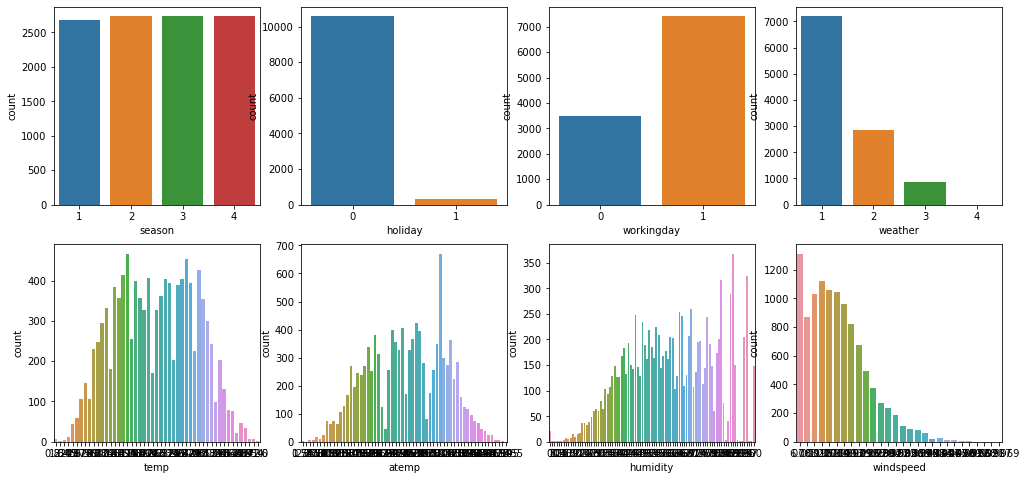

In [9]:
plt.figure(figsize=(17,8))
for i, col in enumerate(test.columns[1:]):
  plt.subplot(2,4,i+1)
  sns.countplot(x=train[col]) # 개수 
plt.show()

*  test 피쳐 분포 확인

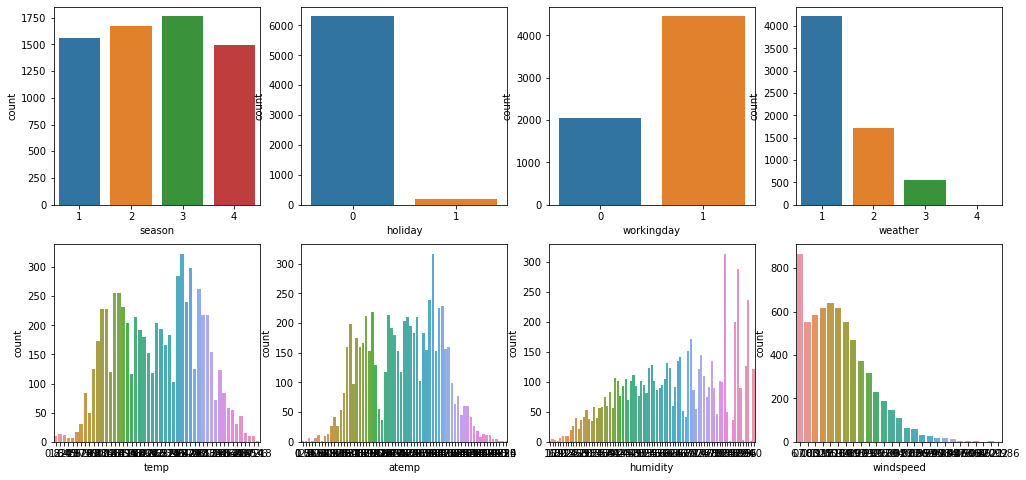

In [10]:
plt.figure(figsize=(17,8))
for i, col in enumerate(test.columns[1:]):
  plt.subplot(2,4,i+1)
  sns.countplot(x=test[col]) # 개수 
plt.show()

* 피쳐 구분

In [11]:
noms = ['season', 'holiday', 'workingday', 'weather']# 범주형
cont = ['temp', 'atemp', 'humidity', 'windspeed']# 연속형

## 전처리 : Basic
---

* output: df_train, X, y, X_train, y_train, X_valid, y_valid, X_test

### | 전처리 진행

* 전처리를 위해 데이터프레임 합치기

In [12]:
df = pd.concat( [train[['count']+noms+cont], test[noms+cont]] )
print(train.shape, test.shape, df.shape)
# 훈련 데이터의 개수 바인딩
n_train = train.shape[0]
#df.head(3)
df.tail(3)

(10886, 12) (6493, 9) (17379, 9)


,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6490,NaN,1,0,1,1,10.66,12.880,60,11.0014
6491,NaN,1,0,1,1,10.66,13.635,56,8.9981
6492,NaN,1,0,1,1,10.66,13.635,65,8.9981


* 전처리
  * 'season', 'weather' 원-핫 인코딩
  * 'count' 로그값으로 변환한 'log_count' 생성

In [13]:
# 해당 피쳐 사라지고, 새로운 피쳐 생성(원-핫 인코딩된)
df = pd.get_dummies(df, columns=['season', 'weather'])
df['log_count'] = np.log(df['count']+1)
df.head(1)

,count,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,log_count
0,16.0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,2.833213


* 'count'와 'log_count' 분포비교

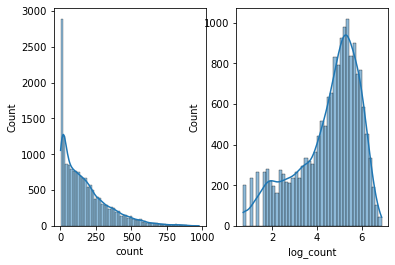

In [14]:
plt.subplot(121)
sns.histplot(data=df, x='count', kde=True)
plt.subplot(122)
sns.histplot(data=df, x='log_count', kde=True)
plt.show()

### | 모델링에 사용할 변수 선택

* 전처리된 데이터 프레임의 피쳐 이름 확인

In [15]:
list(df)

['count',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'log_count']

* 사용할 피쳐 선택

In [16]:
selected = [
            'holiday',
            'workingday',
            'temp',
            'atemp',
            'humidity',
            'windspeed',
            'season_1',
            'season_2',
            'season_3',
            'season_4',
            'weather_1',
            'weather_2',
            'weather_3',
            'weather_4',
            ]

### | 데이터 분할

#### 훈련-테스트 데이터 분할

In [17]:
df_train = df[selected+['log_count']].iloc[:n_train]
X = df_train[selected]
y = df_train['log_count']
X_test = df[selected].iloc[n_train:]
X.shape, y.shape, X_test.shape # 데이터프레임

((10886, 14), (10886,), (6493, 14))

* 훈련 데이터 확인

In [18]:
X.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0


* 테스트 데이터 확인

In [19]:
X_test.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0



#### 훈련-검증 데이터 분할


```
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split()
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape
```

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=1,
                                                      shuffle=True)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape
# 데이터프레임

((8708, 14), (8708,), (2178, 14), (2178,))

In [21]:
X_train.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
3224,0,1,27.88,31.82,89,19.9995,0,0,1,0,0,1,0,0


In [22]:
y_train.head()

3224    4.584967
1299    4.343805
3489    5.556828
7649    3.091042
5950    2.944439
Name: log_count, dtype: float64

## EDA
---

* 훈련 데이터 확인

* 테스트 데이터 확인

### | 범주 자료 인사이트

* 범주 자료형 분포 시각화

* 범주 자료형 클래스별 타겟값 분포 확인

### | 수치자료 인사이트

* 수치자료형 분포 시각화

In [23]:
# windspeed 0 : 결측값. -> ㅇ

* 수치자료형과 타겟값 산점도

* 상관계수 시각화

## 전처리: Advence
---

* output: df_train, X, y, X_train, y_train, X_valid, y_valid, X_test

### | 전처리 진행을 위한 데이터 합치기

* 테스트 데이터 피쳐 기준으로 합치기

In [24]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv(f'data/test.csv')
submission = pd.read_csv(f'data/sampleSubmission.csv')
print(train.shape, test.shape, submission.shape)

(10886, 12) (6493, 9) (6493, 2)


### 이상치 제거

In [25]:
train = train[train["weather"] != 4]

In [26]:
all_data = pd.concat( [train[['count']+noms+cont+["datetime"]], test[noms+cont+["datetime"]]] , ignore_index=True)
print(train.shape, test.shape, df.shape)
# 훈련 데이터의 개수 바인딩
n_train = train.shape[0]
#df.head(3)
all_data.tail(3)

(10885, 12) (6493, 9) (17379, 16)


,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime
17375,NaN,1,0,1,1,10.66,12.880,60,11.0014,2012-12-31 21:00:00
17376,NaN,1,0,1,1,10.66,13.635,56,8.9981,2012-12-31 22:00:00
17377,NaN,1,0,1,1,10.66,13.635,65,8.9981,2012-12-31 23:00:00


### | 피쳐 생성

#### 'datetime' 피쳐에서 월, 일, 시간 등 생성하기

In [27]:
from datetime import datetime
all_data["date"] = all_data["datetime"].apply(lambda x: x.split()[0])
all_data["year"] = all_data["datetime"].apply(lambda x: x.split()[0].split("-")[0])
all_data["month"] = all_data["datetime"].apply(lambda x: x.split()[0].split("-")[1])
all_data["hour"] = all_data["datetime"].apply(lambda x: x.split()[1].split(":")[0])
all_data["weekday"] = all_data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday())
all_data.head(2)

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime,date,year,month,hour,weekday
0,16.0,1,0,0,1,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011-01-01,2011,01,00,5
1,40.0,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 01:00:00,2011-01-01,2011,01,01,5


#### 생성한 피쳐 시각화

* 새롭게 생성된 피쳐 분포 시각화

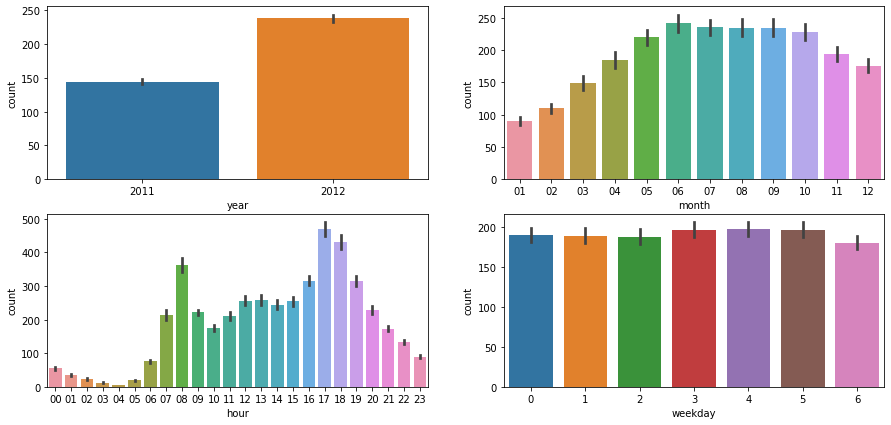

In [28]:
new_features=["year","month","hour","weekday"]
plt.figure(figsize=(15,7))
for i, col in enumerate(new_features):
    plt.subplot(2,2,i+1)
    sns.barplot(data= all_data.iloc[:n_train], x=col,y="count")
plt.show()

* 'hour' 속성에  따른 기타 범주 값 분포 시각화

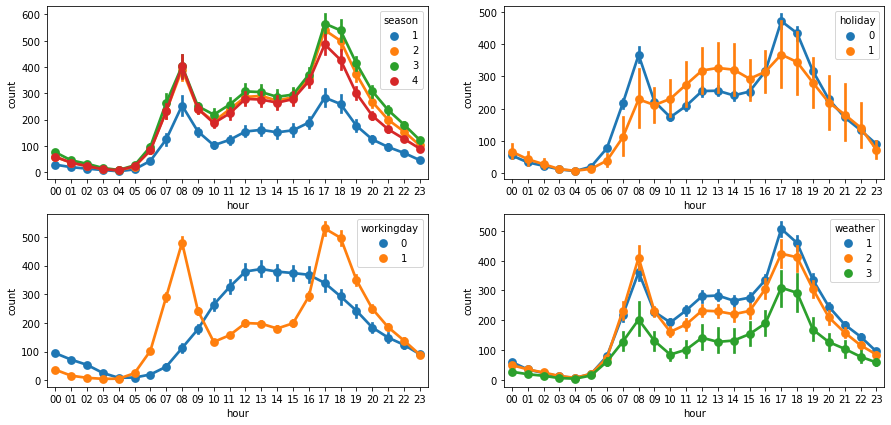

In [29]:
plt.figure(figsize=(15,7))
for i, col in enumerate(noms):
    plt.subplot(2,2,i+1)
    sns.pointplot(data= all_data.iloc[:n_train], x="hour",y="count",hue=col)
plt.show()

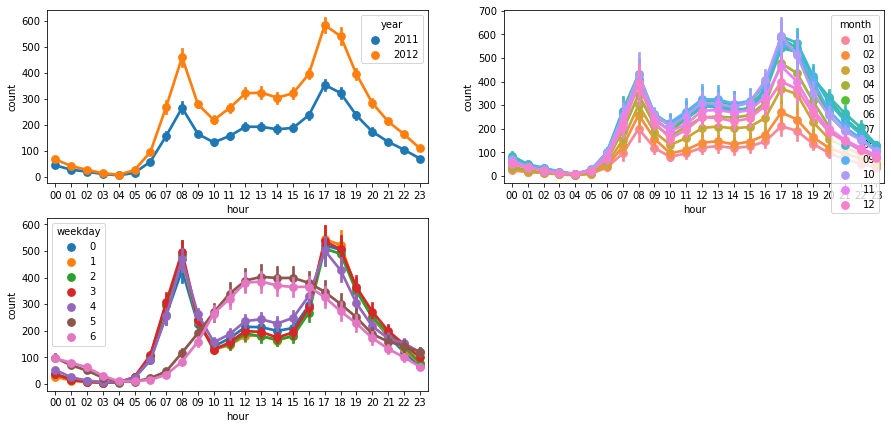

In [30]:
plt.figure(figsize=(15,7))
for i, col in enumerate(["year","month","weekday"]):
    plt.subplot(2,2,i+1)
    sns.pointplot(data= all_data.iloc[:n_train], x="hour",y="count",hue=col)
plt.show()

### | 전처리 진행

* 현재 데이터프레임 확인

In [31]:
all_data.head(3)

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime,date,year,month,hour,weekday
0,16.0,1,0,0,1,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011-01-01,2011,01,00,5
1,40.0,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 01:00:00,2011-01-01,2011,01,01,5
2,32.0,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 02:00:00,2011-01-01,2011,01,02,5


#### 원-핫 인코딩 
* season, weather

In [32]:
all_data = pd.get_dummies(all_data, columns=["season","weather","weekday"])
all_data.head(1)

,count,holiday,workingday,temp,atemp,humidity,windspeed,datetime,date,year,...,weather_2,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,16.0,0,0,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011-01-01,2011,...,0,0,0,0,0,0,0,0,1,0


#### PCA를 통한 차원축소
* temp, atemp

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
all_data["temp_pca"] =pca.fit_transform(all_data[ ["temp", "atemp"]])
all_data.head(1)

,count,holiday,workingday,temp,atemp,humidity,windspeed,datetime,date,year,...,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,temp_pca
0,16.0,0,0,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011-01-01,2011,...,0,0,0,0,0,0,0,1,0,-14.04629


#### 결측값 할당

* 'windspeed' 결측값 (0) 을 RF 로 예측

In [34]:
wind_X = all_data[all_data["windspeed"]!=0].copy()
wind_y = all_data[all_data["windspeed"]==0].copy()

In [35]:
wind_X.drop(["count"],axis=1, inplace=True)

In [36]:
wind_y.drop(["count"],axis=1, inplace=True)

In [37]:
wind_y

,holiday,workingday,temp,atemp,humidity,windspeed,datetime,date,year,month,...,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,temp_pca
0,0,0,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011-01-01,2011,01,...,0,0,0,0,0,0,0,1,0,-14.046290
1,0,0,9.02,13.635,80,0.0,2011-01-01 01:00:00,2011-01-01,2011,01,...,0,0,0,0,0,0,0,1,0,-15.160679
2,0,0,9.02,13.635,80,0.0,2011-01-01 02:00:00,2011-01-01,2011,01,...,0,0,0,0,0,0,0,1,0,-15.160679
3,0,0,9.84,14.395,75,0.0,2011-01-01 03:00:00,2011-01-01,2011,01,...,0,0,0,0,0,0,0,1,0,-14.046290
4,0,0,9.84,14.395,75,0.0,2011-01-01 04:00:00,2011-01-01,2011,01,...,0,0,0,0,0,0,0,1,0,-14.046290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17318,0,0,8.20,12.120,100,0.0,2012-12-29 12:00:00,2012-12-29,2012,12,...,1,0,0,0,0,0,0,1,0,-16.831297
17319,0,0,8.20,12.120,100,0.0,2012-12-29 13:00:00,2012-12-29,2012,12,...,1,0,0,0,0,0,0,1,0,-16.831297
17321,0,0,9.84,12.120,87,0.0,2012-12-29 15:00:00,2012-12-29,2012,12,...,0,0,0,0,0,0,0,1,0,-15.722349
17329,0,0,10.66,12.120,60,0.0,2012-12-29 23:00:00,2012-12-29,2012,12,...,0,0,0,0,0,0,0,1,0,-15.167875


In [38]:
wind_X_train = wind_X.drop(["windspeed","datetime","date"], axis=1)
wind_y_train = wind_X["windspeed"]

In [39]:
wind_X_test = wind_y.drop(["windspeed","datetime","date"], axis=1)

In [40]:
from sklearn.ensemble import RandomForestRegressor
rf_wind = RandomForestRegressor()
rf_wind.fit(wind_X_train, wind_y_train)

RandomForestRegressor()

In [41]:
pred_wind=rf_wind.predict(wind_X_test)

In [42]:
all_data.loc[all_data["windspeed"]==0,"windspeed"]=pred_wind

In [43]:
all_data["windspeed"].describe()

count    17378.000000
mean        14.103960
std          6.824431
min          6.003200
25%          8.998100
50%         12.998000
75%         17.180023
max         56.996900
Name: windspeed, dtype: float64

#### 타겟값 로그변환
* 'log_count' 생성

In [44]:
all_data["log_count"]=np.log(all_data["count"])

In [45]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   count       10885 non-null  float64
 1   holiday     17378 non-null  int64  
 2   workingday  17378 non-null  int64  
 3   temp        17378 non-null  float64
 4   atemp       17378 non-null  float64
 5   humidity    17378 non-null  int64  
 6   windspeed   17378 non-null  float64
 7   datetime    17378 non-null  object 
 8   date        17378 non-null  object 
 9   year        17378 non-null  object 
 10  month       17378 non-null  object 
 11  hour        17378 non-null  object 
 12  season_1    17378 non-null  uint8  
 13  season_2    17378 non-null  uint8  
 14  season_3    17378 non-null  uint8  
 15  season_4    17378 non-null  uint8  
 16  weather_1   17378 non-null  uint8  
 17  weather_2   17378 non-null  uint8  
 18  weather_3   17378 non-null  uint8  
 19  weather_4   17378 non-nul

In [46]:
all_data["year"] = all_data["year"].astype(int)
all_data["hour"] = all_data["hour"].astype(int)

### | 모델링에 사용할 변수 선택

* 전처리된 데이터 프레임의 피쳐 이름 확인

In [47]:
list(all_data)

['count',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'datetime',
 'date',
 'year',
 'month',
 'hour',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'temp_pca',
 'log_count']

* 사용할 피쳐 선택

In [48]:
selected = [
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

### | 데이터 분할

#### 훈련-테스트 데이터 분할

In [49]:
df_train = all_data[selected + ["log_count"]].iloc[:n_train]
X = df_train[selected]
y = df_train["log_count"]
X_test = all_data[selected].iloc[n_train:]
X.shape, y.shape, X_test.shape

((10885, 23), (10885,), (6493, 23))

* 훈련 데이터 확인

In [50]:
X.head(3)

,holiday,workingday,temp,atemp,humidity,windspeed,year,hour,season_1,season_2,...,weather_2,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,9.84,14.395,81,7.092285,2011,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,9.02,13.635,80,6.522785,2011,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,9.02,13.635,80,6.342890,2011,2,1,0,...,0,0,0,0,0,0,0,0,1,0


* 테스트 데이터 확인

In [51]:
X_test.head(3)

,holiday,workingday,temp,atemp,humidity,windspeed,year,hour,season_1,season_2,...,weather_2,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
10885,0,1,10.66,11.365,56,26.002700,2011,0,1,0,...,0,0,0,0,0,0,1,0,0,0
10886,0,1,10.66,13.635,56,9.970136,2011,1,1,0,...,0,0,0,0,0,0,1,0,0,0
10887,0,1,10.66,13.635,56,9.960019,2011,2,1,0,...,0,0,0,0,0,0,1,0,0,0



#### 훈련-검증 데이터 분할
```
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split()
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape
```

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=1,
                                                      shuffle=True)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((8708, 23), (8708,), (2177, 23), (2177,), (6493, 23))

## 모델링
---

* input : X_train, X_valid, y_train, y_valid, X_test
* output: submission file

### | 평가 지표 정의 (RMSLE)

* RMSLE 정의

In [210]:
from sklearn.metrics import make_scorer

# np.log(y+1)
def inverse_log(y):
  return np.exp(y)-1

def rmsle(y_true, y_pred, inverse=True):
  if inverse:
    y_true = inverse_log(y_true)
    y_pred = inverse_log(y_pred)
  return np.sqrt(np.mean(  ( np.log(y_true+1) - np.log(y_pred+1) )**2  ) )
RMSLE = make_scorer(rmsle, greater_is_better=False)

### | 회귀 모델 탐색

#### 모델링

In [127]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

logistic = LinearRegression()
ridge = Ridge()
lasso = Lasso()
rf = RandomForestRegressor()
bagging = BaggingRegressor()
ada = AdaBoostRegressor()
gbrt = GradientBoostingRegressor()
xgb = XGBRegressor()
lgb = LGBMRegressor()

#### 평가

* 성능평가

In [211]:
models = ['logistic', 'ridge', 'lasso', 'rf', 'bagging', 
          'ada', 'gbrt', 'xgb', 'lgb']
for model in models:
  eval(model).fit(X_train, y_train)
  y_pred_train = eval(model).predict(X_train)
  y_pred_valid = eval(model).predict(X_valid)
  print (f'{model} [train] {rmsle(y_train, y_pred_train):.2f}  [valid] {rmsle(y_valid, y_pred_valid):.2f}')

logistic [train] 1.06  [valid] 1.07
ridge [train] 1.06  [valid] 1.07
lasso [train] 1.13  [valid] 1.13
rf [train] 0.13  [valid] 0.35
bagging [train] 0.15  [valid] 0.38
ada [train] 0.70  [valid] 0.70
gbrt [train] 0.44  [valid] 0.47
xgb [train] 0.19  [valid] 0.34
lgb [train] 0.28  [valid] 0.33


* 타겟 분포 및 y true, y_pred 산점도

In [212]:
def draw_results(model, X, y):
    y_pred = model.predict(X)
    print(f'score:{rmsle(y, y_pred):.3f}')
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    sns.histplot(inverse_log(y))
    plt.subplot(132)
    sns.histplot(inverse_log(y_pred))
    plt.subplot(133)
    sns.scatterplot(x=inverse_log(y), y=inverse_log(y_pred))
    plt.plot([0, 1000], [0, 1000], c='r', linestyle=':')
    plt.show()

* 시각화

score:0.353


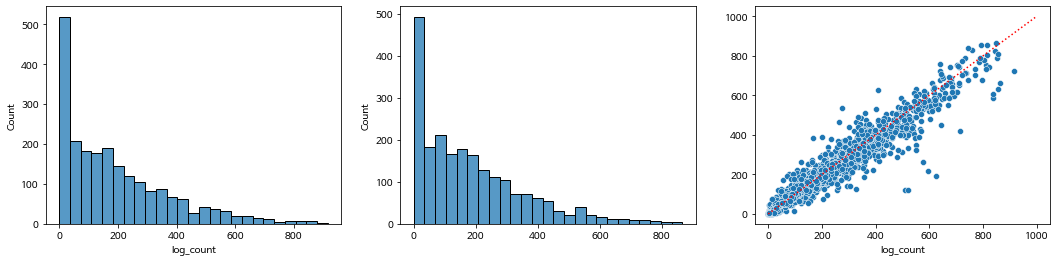

score:0.470


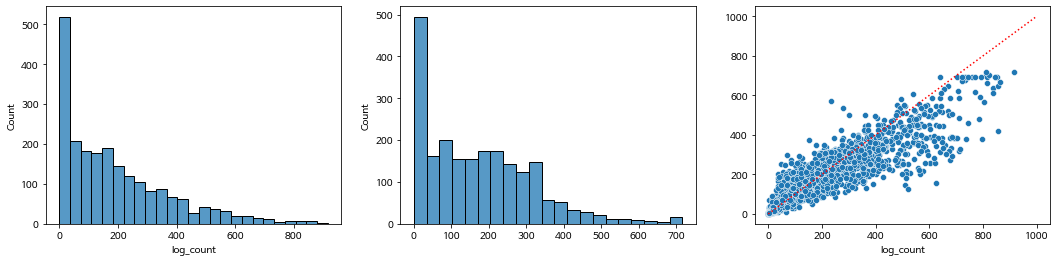

score:0.341


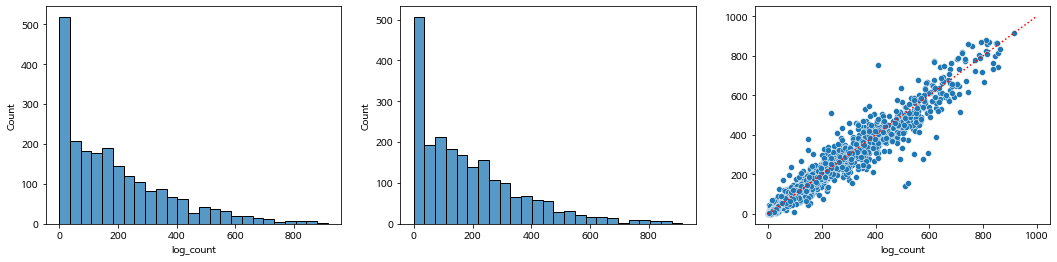

score:0.334


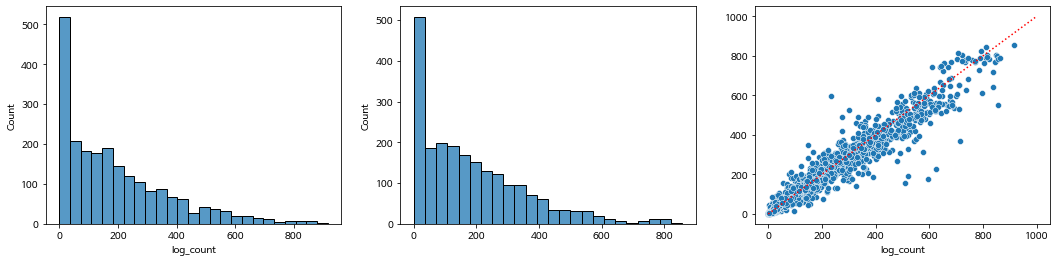

In [213]:
for model in [rf, gbrt, xgb, lgb]:
  draw_results(model, X_valid, y_valid)

### | 그리드 서치로 모델 하이퍼파라미터 최적화

#### 모델링

* 랜덤 포레스트 그리드 서치

In [214]:
from sklearn.model_selection import GridSearchCV

param = {
    "min_samples_split": [3, 4, 6, 10],
    "n_estimators": [70, 100,140],
    "random_state": [1]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=1),
                       param,
                       cv=10,
                       scoring=RMSLE)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=1),
             param_grid={'min_samples_split': [3, 4, 6, 10],
                         'n_estimators': [70, 100, 140], 'random_state': [1]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [221]:
y_pred_train = rf_grid.predict(X_train)
y_pred_valid = rf_grid.predict(X_valid)

In [222]:
print(f"RF Grid [train] {rmsle(y_train, y_pred_train): .2f} [valid] {rmsle(y_valid, y_pred_valid): .2f}")

RF Grid [train]  0.14 [valid]  0.35


* LGBM 그리드 서치

In [217]:
from sklearn.model_selection import GridSearchCV

param = {"n_estimators": [400,700,1000],"max_depth":[15,20,25],"num_leaves":[50,100,200],"min_split_gain":[0.3,0.4]}
lgb_grid = GridSearchCV( LGBMRegressor(random_state=1),
                       param,
                       cv=10,
                       scoring=RMSLE)

lgb_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(random_state=1),
             param_grid={'max_depth': [15, 20, 25],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [400, 700, 1000],
                         'num_leaves': [50, 100, 200]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [218]:
y_pred_train = lgb_grid.predict(X_train)
y_pred_valid = lgb_grid.predict(X_valid)

In [219]:
print(f"LGBM Grid [train] {rmsle(y_train, y_pred_train): .2f} [valid] {rmsle(y_valid, y_pred_valid): .2f}")

LGBM Grid [train]  0.31 [valid]  0.38


#### 평가

* 성능평가

* 시각화

score:0.370


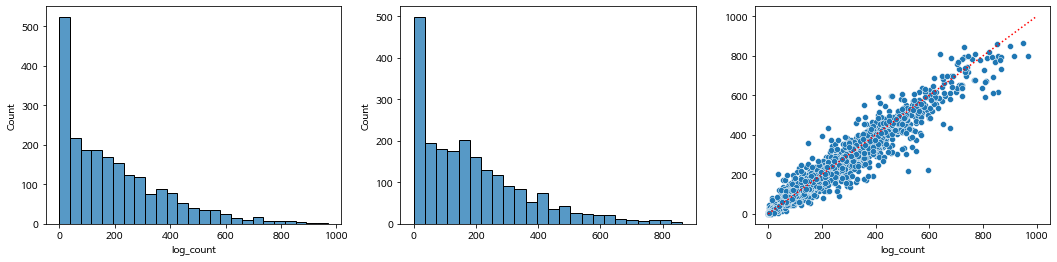

score:0.409


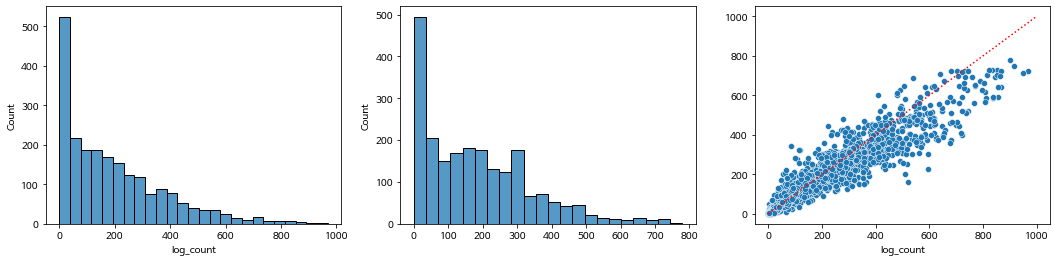

In [139]:
for model in [rf_grid, lgb_grid]:
    draw_results(model, X_valid, y_valid)

### | 결과제출

#### 테스트 데이터 예측

* 최적화된 모델을 이용한 테스트 예측

In [223]:
pred_rfgrid[:5]

array([8.83649983, 3.02459246, 1.29144074, 1.25270707, 0.83895491])

In [224]:
pred_rfgrid = rf_grid.predict(X_test)
pred_rfgrid = inverse_log(pred_rfgrid)
print(pred_rfgrid)

[  9.07871499   2.76498461   1.71756494 ... 101.66045286  84.36132349
  44.82683056]


#### submission 파일 작성

* submission 할당

In [225]:
submission["count"] = pred_rfgrid
submission.head()

,datetime,count
0,2011-01-20 00:00:00,9.078715
1,2011-01-20 01:00:00,2.764985
2,2011-01-20 02:00:00,1.717565
3,2011-01-20 03:00:00,1.626425
4,2011-01-20 04:00:00,1.300207


* submission 파일 변환

In [226]:
submission.to_csv("submission_3.csv", index=False)

#### 제출 결과 정리

* 전처리 - 그리드 서치 - 앙상블 :


## Pycaret
---

### | 환경세팅

* sklearn 버전 재세팅

```
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
```

In [1]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=d6d7e1a6e1415cb03586d3f62abab6f78c0be20aa71ebee7f6401eeb217f249c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


* 버전 확인

```
import sklearn
sklearn.__version__
import sys
sys.version
```

In [4]:
import sklearn
sklearn.__version__
import sys
sys.version

'3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]'

* pycaret, Jinja2 설치

```
!pip install pycaret
!pip install Jinja2==3.0.1

미니콘다 프롬프트에서 실행
```

In [ ]:
!pip install --user pycaret
!pip install Jinja2==3.0.1

* pycaret regression 사용

```
from pycaret.regression import *
```

In [55]:
from pycaret.regression import *

### | 데이터 셋업

In [56]:
df_train

,holiday,workingday,temp,atemp,humidity,windspeed,year,hour,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,log_count
0,0,0,9.84,14.395,81,7.092285,2011,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2.772589
1,0,0,9.02,13.635,80,6.522785,2011,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3.688879
2,0,0,9.02,13.635,80,6.342890,2011,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3.465736
3,0,0,9.84,14.395,75,6.462619,2011,3,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2.564949
4,0,0,9.84,14.395,75,6.352672,2011,4,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10880,0,1,15.58,19.695,50,26.002700,2012,19,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,5.817111
10881,0,1,14.76,17.425,57,15.001300,2012,20,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,5.484797
10882,0,1,13.94,15.910,61,15.001300,2012,21,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,5.123964
10883,0,1,13.94,17.425,61,6.003200,2012,22,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,4.859812


In [57]:
data = setup(data=df_train, target="log_count", train_size=0.8)

,Description,Value
0,session_id,1031
1,Target,log_count
2,Original Data,"(10885, 24)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8708, 23)"


### | 모델링

In [58]:
compare_models(sort="RMSLE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2207,0.1085,0.3292,0.9509,0.1108,0.0730,0.0190
rf,Random Forest Regressor,0.2265,0.1208,0.3473,0.9453,0.1162,0.0762,0.2310
et,Extra Trees Regressor,0.2271,0.1237,0.3514,0.9441,0.1214,0.0775,0.2230
gbr,Gradient Boosting Regressor,0.3291,0.1942,0.4405,0.9122,0.1304,0.1005,0.0900
dt,Decision Tree Regressor,0.3111,0.2310,0.4799,0.8956,0.1597,0.1039,0.0090
ada,AdaBoost Regressor,0.5450,0.4612,0.6788,0.7910,0.1711,0.1464,0.0640
knn,K Neighbors Regressor,0.5847,0.6278,0.7919,0.7162,0.2114,0.1836,0.0120
lar,Least Angle Regression,0.8299,1.1421,1.0681,0.4839,0.2696,0.2704,0.0040
ridge,Ridge Regression,0.8299,1.1421,1.0681,0.4839,0.2696,0.2704,0.0060
lr,Linear Regression,0.8299,1.1419,1.0680,0.4840,0.2696,0.2703,0.3830


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1031, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#앙상블

In [60]:
blender = blend_models(estimator_list=compare_models(n_select=3, sort="RMSLE"))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2130,0.1044,0.3231,0.9542,0.1076,0.0771
1,0.2220,0.1208,0.3475,0.9486,0.1309,0.0745
2,0.2176,0.1125,0.3353,0.9469,0.1092,0.0738
3,0.2219,0.1123,0.3351,0.9513,0.1127,0.0757
4,0.2047,0.1014,0.3185,0.9570,0.1170,0.0719
5,0.2129,0.1022,0.3198,0.9519,0.1088,0.0693
6,0.2125,0.1028,0.3206,0.9549,0.1077,0.0763
7,0.2063,0.1090,0.3301,0.9465,0.1092,0.0628
8,0.2210,0.1118,0.3344,0.9490,0.1148,0.0758


### | 최종 모델 선택 및 예측

In [61]:
# blender 에 최종적으로 모든 데이터 (train+valid)
final = finalize_model(blender)

In [62]:
y_pred = predict_model(final, data=X_test)

In [79]:
y_pred = y_pred.reset_index()

### | 결과 제출

In [82]:
pred = np.exp(y_pred["Label"])-1

In [83]:
pred

0         9.486548
1         3.374111
2         1.569656
3         1.619071
4         1.506683
           ...    
6488    197.609347
6489    144.013173
6490    102.790716
6491     88.669983
6492     44.604539
Name: Label, Length: 6493, dtype: float64

In [84]:
submission["count"]=pred

In [88]:
submission.to_csv("submission_caret.csv",index=False)

In [89]:
pd.read_csv("submission_caret.csv")

,datetime,count
0,2011-01-20 00:00:00,9.486548
1,2011-01-20 01:00:00,3.374111
2,2011-01-20 02:00:00,1.569656
3,2011-01-20 03:00:00,1.619071
4,2011-01-20 04:00:00,1.506683
...,...,...
6488,2012-12-31 19:00:00,197.609347
6489,2012-12-31 20:00:00,144.013173
6490,2012-12-31 21:00:00,102.790716
6491,2012-12-31 22:00:00,88.669983


In [87]:
X_test

,holiday,workingday,temp,atemp,humidity,windspeed,year,hour,season_1,season_2,...,weather_2,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
10885,0,1,10.66,11.365,56,26.002700,2011,0,1,0,...,0,0,0,0,0,0,1,0,0,0
10886,0,1,10.66,13.635,56,9.970136,2011,1,1,0,...,0,0,0,0,0,0,1,0,0,0
10887,0,1,10.66,13.635,56,9.960019,2011,2,1,0,...,0,0,0,0,0,0,1,0,0,0
10888,0,1,10.66,12.880,56,11.001400,2011,3,1,0,...,0,0,0,0,0,0,1,0,0,0
10889,0,1,10.66,12.880,56,11.001400,2011,4,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,0,1,10.66,12.880,60,11.001400,2012,19,1,0,...,1,0,0,1,0,0,0,0,0,0
17374,0,1,10.66,12.880,60,11.001400,2012,20,1,0,...,1,0,0,1,0,0,0,0,0,0
17375,0,1,10.66,12.880,60,11.001400,2012,21,1,0,...,0,0,0,1,0,0,0,0,0,0
17376,0,1,10.66,13.635,56,8.998100,2012,22,1,0,...,0,0,0,1,0,0,0,0,0,0
